In [1]:
import numpy as np
# from feature_extraction import get_patches
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

d:\Python\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import clean as clean

In [10]:
X_train = np.load('../train_test/X_train_balanced.npy')
y_train = np.load('../train_test/y_train_balanced.npy')
X_test = np.load('../train_test/X_test.npy')
y_test = np.load('../train_test/y_test.npy')

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(66130, 43) (66130,) (8408, 43) (8408,)


In [12]:
from sklearn.model_selection import train_test_split

# Assuming you want 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"X_train_new shape: {X_train.shape}")
print(f"y_train_new shape: {y_train.shape}")
print(f"X_valid shape: {X_val.shape}")
print(f"y_valid shape: {y_val.shape}")

X_train_new shape: (52904, 43)
y_train_new shape: (52904,)
X_valid shape: (13226, 43)
y_valid shape: (13226,)


In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.img_labels = torch.tensor(y).type(torch.LongTensor)
        self.img_labels[self.img_labels == -1] = 0
        self.img_features = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_features[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [14]:
# Custom dataset for tabular data
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def preprocess_data(X):
    # Replace NaNs with column mean
    return np.nan_to_num(X, nan=np.nanmean(X, axis=0))

In [15]:
class TabularCNN(nn.Module):
    def __init__(self):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 1 * 2, 128)  # Adjust dimensions as needed
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Raw logits, no sigmoid
        return x

In [16]:

# Pad features to make the total 45
X_train = np.pad(X_train, ((0, 0), (0, 2)), mode='constant')  # Pad 2 zeros to the last dimension
X_val = np.pad(X_val, ((0, 0), (0, 2)), mode='constant')      # Pad 2 zeros to the last dimension
X_test = np.pad(X_test, ((0, 0), (0, 2)), mode='constant')    # Pad 2 zeros to the last dimension

# Reshape for CNN (1x5x9 grids)
X_train = X_train.reshape(-1, 1, 5, 9)
X_val = X_val.reshape(-1, 1, 5, 9)
X_test = X_test.reshape(-1, 1, 5, 9)

# Create datasets and dataloaders
train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)
test_dataset = TabularDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
# Custom loss function combining BCE and FNR penalty
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CustomLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.alpha = alpha  # Weight for FNR penalty

    def forward(self, outputs, labels):
        # Calculate BCE loss
        bce_loss = self.bce(outputs, labels)

        # Calculate FNR
        preds = (outputs > 0.5).float()
        false_negatives = ((labels == 1) & (preds == 0)).sum().float()
        total_positives = (labels == 1).sum().float()
        fnr = false_negatives / total_positives if total_positives > 0 else 0

        # Combine BCE loss and FNR penalty
        loss = bce_loss + self.alpha * fnr
        return loss

In [18]:
# Initialize model
model = TabularCNN()

# Calculate class weights
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
pos_weight = num_negatives / num_positives

# Convert to a tensor for PyTorch
class_weight = torch.tensor([pos_weight], dtype=torch.float32)

# Define weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to track metrics
loss_history = []
recall_history = []
fnr_history = []

# Training loop
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Raw logits
        loss = criterion(outputs, labels)  # Weighted BCE loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record loss
    avg_loss = running_loss / len(train_dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    # Evaluate metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        total_positives = 0
        true_positives = 0
        false_negatives = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs).squeeze()
                probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
                preds = (probabilities > 0.5).float()
                true_positives += ((preds == 1) & (labels == 1)).sum().item()
                false_negatives += ((labels == 1) & (preds == 0)).sum().item()
                total_positives += (labels == 1).sum().item()

        # Calculate recall and FNR
        recall = true_positives / total_positives if total_positives > 0 else 0
        fnr = false_negatives / total_positives if total_positives > 0 else 0

        recall_history.append(recall)
        fnr_history.append(fnr)

        print(f"Epoch {epoch + 1}, Recall: {recall:.4f}, FNR: {fnr:.4f}")

Epoch 1, Loss: 2.8384
Epoch 2, Loss: 0.2624
Epoch 3, Loss: 0.1876
Epoch 4, Loss: 0.1668
Epoch 5, Loss: 0.1524
Epoch 6, Loss: 0.1687
Epoch 7, Loss: 0.1342
Epoch 8, Loss: 0.1304
Epoch 9, Loss: 0.1411
Epoch 10, Loss: 0.1267
Epoch 10, Recall: 0.9898, FNR: 0.0102
Epoch 11, Loss: 0.1238
Epoch 12, Loss: 0.1216
Epoch 13, Loss: 0.1219
Epoch 14, Loss: 0.1250
Epoch 15, Loss: 0.1360
Epoch 16, Loss: 0.1193
Epoch 17, Loss: 0.1128
Epoch 18, Loss: 0.1111
Epoch 19, Loss: 0.1217
Epoch 20, Loss: 0.1073
Epoch 20, Recall: 0.9828, FNR: 0.0172
Epoch 21, Loss: 0.1070
Epoch 22, Loss: 0.1358
Epoch 23, Loss: 0.1029
Epoch 24, Loss: 0.1144
Epoch 25, Loss: 0.1006
Epoch 26, Loss: 0.0999
Epoch 27, Loss: 0.1142
Epoch 28, Loss: 0.1053
Epoch 29, Loss: 0.1060
Epoch 30, Loss: 0.0985
Epoch 30, Recall: 0.9983, FNR: 0.0017
Epoch 31, Loss: 0.0967
Epoch 32, Loss: 0.0969
Epoch 33, Loss: 0.0930
Epoch 34, Loss: 0.0917
Epoch 35, Loss: 0.1001
Epoch 36, Loss: 0.0978
Epoch 37, Loss: 0.1010
Epoch 38, Loss: 0.0861
Epoch 39, Loss: 0.086

In [19]:
# Save the trained model
model_path = "cnn/trained_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to cnn/trained_cnn.pth


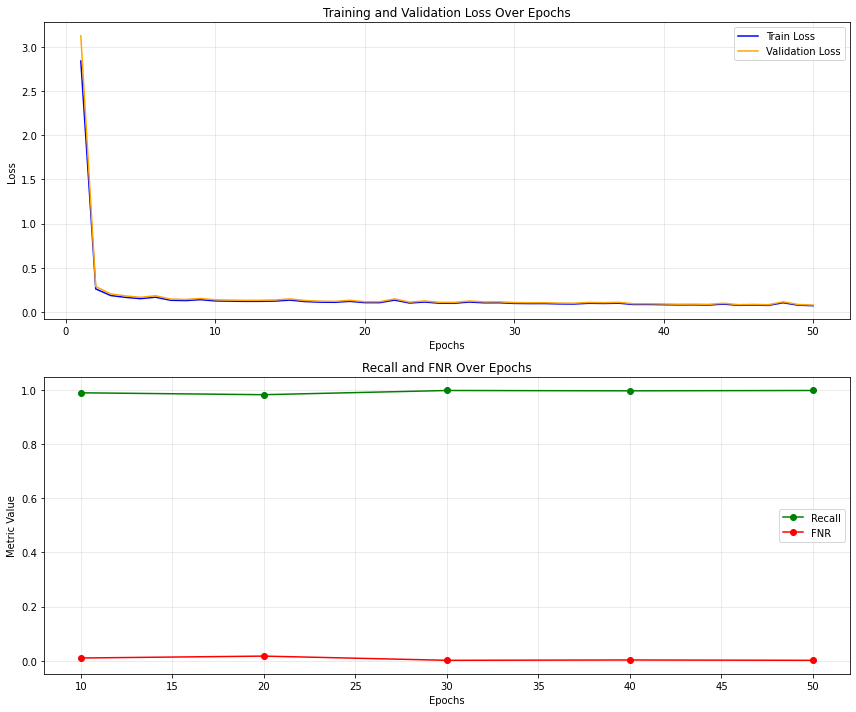

In [20]:
# Create a range for the epochs
epochs = range(1, 51)  # 50 epochs
metric_epochs = range(10, 51, 10)  # For recall and FNR, every 10 epochs

# Example data: Make sure loss_history and val_loss_history are available
val_loss_history = [loss * 1.1 for loss in loss_history]  # Example validation loss for illustration

# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot loss in the first subplot
axs[0].plot(epochs, loss_history, label="Train Loss", color="blue")
axs[0].plot(epochs, val_loss_history, label="Validation Loss", color="orange")
axs[0].set_title("Training and Validation Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(alpha=0.3)

# Plot recall and FNR in the second subplot
axs[1].plot(metric_epochs, recall_history, label="Recall", marker='o', color="green")
axs[1].plot(metric_epochs, fnr_history, label="FNR", marker='o', color="red")
axs[1].set_title("Recall and FNR Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Metric Value")
axs[1].legend()
axs[1].grid(alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
# plt.savefig("train_valid_loss_recall_fnr.png")
plt.show()


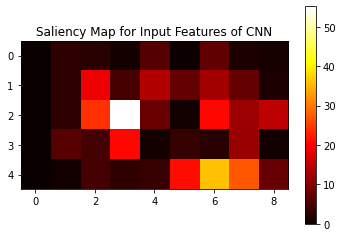

In [24]:
model.eval()

# Select a single sample for analysis
sample = torch.tensor(X_test[0:1], dtype=torch.float32, requires_grad=True)

# Forward pass
output = model(sample)
output.backward(torch.ones_like(output))  # Backpropagate

# Saliency map is the absolute value of the gradients
saliency = sample.grad.abs().squeeze().detach().numpy()

# Plot saliency heatmap
plt.imshow(saliency, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Saliency Map for Input Features of CNN")
plt.savefig("../Image/saliency_map.pdf")
plt.show()


In [25]:
import numpy as np
import pandas as pd

# Feature names (including padded zeros at the end for CNN input compatibility)
feature_names = [
    'PatNum', 'EmplType', 'Certification', 'InjuryMech', 'High_impact_InjSev', 
    'Amnesia_verb', 'LOCSeparate', 'Seiz', 'ActNorm', 'HA_verb', 'Vomit', 
    'Dizzy', 'Intubated', 'Paralyzed', 'Sedated', 'GCSEye', 'GCSVerbal', 
    'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS', 'SFxPalp', 'FontBulg', 
    'SFxBas', 'Hema', 'Clav', 'ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 
    'ClavPar', 'ClavTem', 'NeuroD', 'OSI', 'Drugs', 'AgeInMonth', 
    'AgeinYears', 'AgeTwoPlus', 'Gender', 'Ethnicity', 'Race', 'Observed', 
    'EDDisposition', 'Padding1', 'Padding2'
]

# Aggregate saliency maps over the test set
model.eval()
saliency_map = []

for i in range(len(X_test)):
    sample = torch.tensor(X_test[i:i+1], dtype=torch.float32, requires_grad=True)
    output = model(sample)
    output.backward(torch.ones_like(output))
    saliency = sample.grad.abs().squeeze().detach().numpy()
    saliency_map.append(saliency)

# Average saliency values across the test set
avg_saliency = np.mean(saliency_map, axis=0)

# Create a DataFrame for feature importance
saliency_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_saliency.flatten()
})

# Remove padding features
saliency_df = saliency_df[~saliency_df['Feature'].str.contains("Padding")]

# Sort features by importance
saliency_df = saliency_df.sort_values(by='Importance', ascending=False)

# Display top 10 features
print(saliency_df.head(10))


          Feature  Importance
42  EDDisposition   70.168602
20            AMS   46.524891
21        SFxPalp   23.043610
34          Drugs   19.724960
29        ClavOcc   18.773315
26       ClavFace   17.326120
24           Hema   16.802305
10          Vomit   16.749733
23         SFxBas   16.088211
15         GCSEye   14.274961


In [24]:
model.eval()

# Create a list to store probabilities
probabilities_list = []

# Get probabilities for the test set
with torch.no_grad():
    for inputs, _ in test_dataloader:  # Only inputs needed for predictions
        outputs = model(inputs).squeeze()  # Raw logits
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
        probabilities_list.append(probabilities.cpu().numpy())

# Concatenate all probabilities into a single array
probabilities_test = np.concatenate(probabilities_list, axis=0)

# Save probabilities to a .npy file
np.save("../results/cnn.npy", probabilities_test)


In [26]:

from sklearn.metrics import classification_report, confusion_matrix

In [28]:
y_pred = probabilities_test
# threshold of 0.2
y_pred[y_pred > 0.2] = 1
y_pred[y_pred <= 0.2] = 0


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[7857  397]
 [  18  136]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9977    0.9519    0.9743      8254
         1.0     0.2552    0.8831    0.3959       154

    accuracy                         0.9506      8408
   macro avg     0.6264    0.9175    0.6851      8408
weighted avg     0.9841    0.9506    0.9637      8408

